# Поиск изменений во временном ряде

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from collections import deque

In [6]:
from collections import defaultdict
np.random.seed(seed=111111)
np.set_printoptions(precision=3, suppress=True)

## 1. Простое мат ожидание

Рассмотрим сигнал

In [21]:
signal = pd.read_csv("numbers-on-unemployment-benefits.csv", parse_dates=True, index_col='Month')
signal

,Numbers on Unemployment Benefits in Australia: monthly Jan 1956 ? Jul 1992
Month,
1956-01,4742.0
1956-02,6128.0
1956-03,6494.0
1956-04,5379.0
1956-05,6011.0
...,...
1992-04,826297.0
1992-05,838390.0
1992-06,851831.0


Отрезаем итоги и сокращаем название столбца со значениями

In [32]:
sig1 = signal[:-1]
sig1.rename(columns={'Numbers on Unemployment Benefits in Australia: monthly Jan 1956 ? Jul 1992': 'Numbers'}, inplace=True)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [33]:
sig1 = sig1.Numbers
sig1

Month
1956-01      4742.0
1956-02      6128.0
1956-03      6494.0
1956-04      5379.0
1956-05      6011.0
             ...   
1992-03    818102.0
1992-04    826297.0
1992-05    838390.0
1992-06    851831.0
1992-07    856505.0
Name: Numbers, Length: 439, dtype: float64

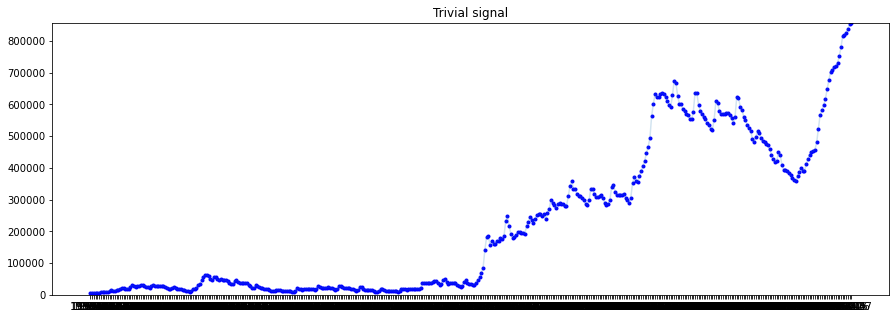

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(sig1, 'b.')
plt.plot(sig1, '-', alpha=0.2)
plt.ylim(0, sig1.Numbers.max())
plt.title("Trivial signal")
plt.show()

In [25]:
class MeanDetector:
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.total_val = 0
        self.count = 0
        self.mean = 0
    
    def update(self, new_signal_value):
        self.count += 1
        self.total_val += new_signal_value
        self.mean = self.total_val / self.count
    
    def check(self, new_signal_value): 
        threshold_level = self.mean * self.threshold
        
        if np.abs(new_signal_value - self.mean) > threshold_level:
            return True
        return False

In [35]:
def simulate(detector, signal):
    stop_points = []
    for i, value in enumerate(signal):
        detector.update(value)
        if detector.check(value):
            stop_points.append(i)
    
    plt.figure(figsize=(14,8))
    plt.plot(signal, 'b.')
    plt.plot(signal, 'b-', alpha=0.15)
    plt.title('Signal')
    
    if stop_points:
        plt.vlines(x=stop_points[0], ymin=0, ymax=np.max(signal),
                      colors='r', linestyles='dotted')
    
    plt.show()

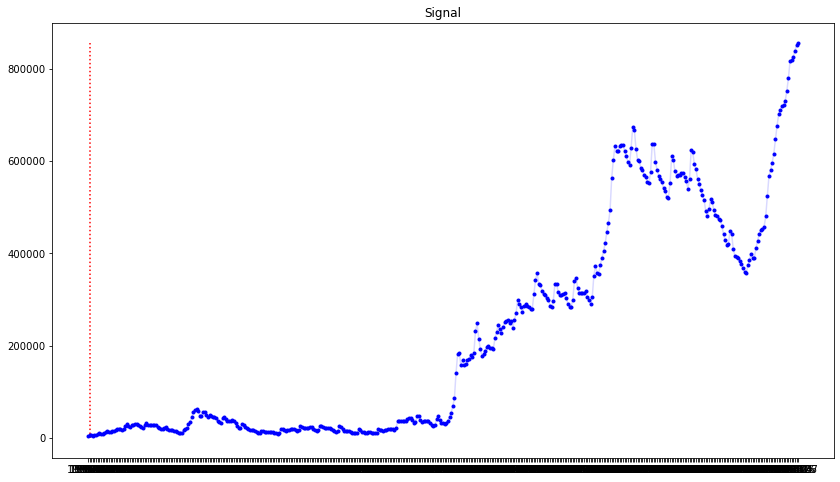

In [36]:
simulate(MeanDetector(), sig1)

Сработал почти сразу

## 2. Потоковые окна

In [37]:
class ZScoreDetector:
    def __init__(self, window_size = 100, threshold=0.05):
        self.threshold = threshold
        self.window_size = window_size
        self.k = 0  
        self.g_mean = 0.0  # global mean  
        self.s = 0.0  # for Welford's method. variance = s / (k + 1)
        self.window = deque(maxlen = window_size)
        self.z_score = np.nan
        
    def update(self, new_signal_value):
        x = new_signal_value
        
        # Добавляем в окно
        self.window.append(x)
        
        # Считаем статистики
        oldm = self.g_mean
        newm = oldm + (x - oldm) / (self.k + 1)
        s = self.s + (x - newm) * (x - oldm)
        g_mean = newm 
        g_std = np.sqrt(s / (self.k+1))
        
        # Считаем статистикии по выборке
        w_mean = np.mean(self.window)
        w_std = np.std(self.window)

        # Считаем Z-score
        std_diff = (g_std - w_std) / g_std        
        SE = g_std / np.sqrt(self.window_size)
        mean_diff = (g_mean - w_mean) / g_mean
        self.z_score = (w_mean - g_mean) / SE
        
        # Обновлем атрибуты
        self.g_mean = g_mean
        self.s = s
        
        self.k += 1
    
    def check(self, new_signal_value):
        if np.abs(self.z_score) > self.threshold:
            return True
        return False

<ipython-input-37-f91433843e00>:29: RuntimeWarning: invalid value encountered in double_scalars
  std_diff = (g_std - w_std) / g_std
<ipython-input-37-f91433843e00>:32: RuntimeWarning: invalid value encountered in double_scalars
  self.z_score = (w_mean - g_mean) / SE


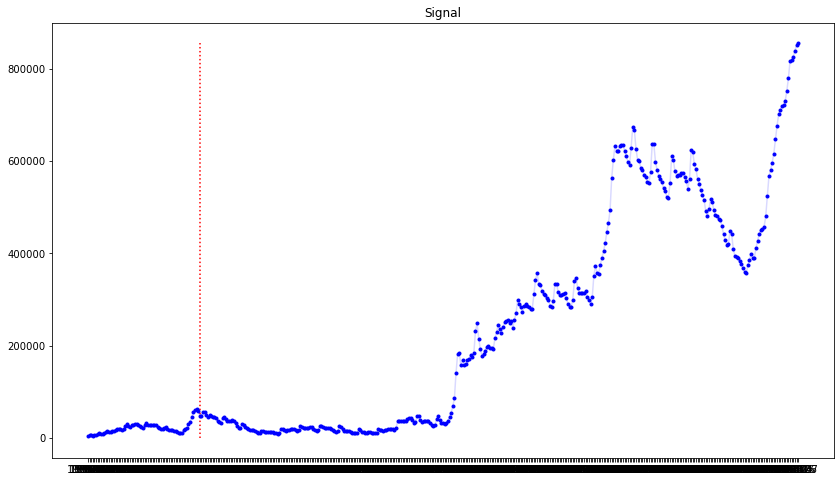

In [38]:
simulate(ZScoreDetector(window_size=10, threshold=5.0), sig1)

### 3. Кумулятивные суммы

In [39]:
__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"

def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):
    """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : positive number, optional (default = 1)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 0)
        drift term that prevents any change in the absence of change.
    ending : bool, optional (default = False)
        True (1) to estimate when the change ends; False (0) otherwise.
    show : bool, optional (default = True)
        True (1) plots data in matplotlib figure, False (0) don't plot.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ta : 1D array_like [indi, indf], int
        alarm time (index of when the change was detected).
    tai : 1D array_like, int
        index of when the change started.
    taf : 1D array_like, int
        index of when the change ended (if `ending` is True).
    amp : 1D array_like, float
        amplitude of changes (if `ending` is True).

    Notes
    -----
    Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
    Start with a very large `threshold`.
    Choose `drift` to one half of the expected change, or adjust `drift` such
    that `g` = 0 more than 50% of the time.
    Then set the `threshold` so the required number of false alarms (this can
    be done automatically) or delay for detection is obtained.
    If faster detection is sought, try to decrease `drift`.
    If fewer false alarms are wanted, try to increase `drift`.
    If there is a subset of the change times that does not make sense,
    try to increase `drift`.

    Note that by default repeated sequential changes, i.e., changes that have
    the same beginning (`tai`) are not deleted because the changes were
    detected by the alarm (`ta`) at different instants. This is how the
    classical CUSUM algorithm operates.

    If you want to delete the repeated sequential changes and keep only the
    beginning of the first sequential change, set the parameter `ending` to
    True. In this case, the index of the ending of the change (`taf`) and the
    amplitude of the change (or of the total amplitude for a repeated
    sequential change) are calculated and only the first change of the repeated
    sequential changes is kept. In this case, it is likely that `ta`, `tai`,
    and `taf` will have less values than when `ending` was set to False.

    See this IPython Notebook [2]_.

    References
    ----------
    .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

    Examples
    --------
    >>> from detect_cusum import detect_cusum
    >>> x = np.random.randn(300)/5
    >>> x[100:200] += np.arange(0, 4, 4/100)
    >>> ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)

    >>> x = np.random.randn(300)
    >>> x[100:200] += 6
    >>> detect_cusum(x, 4, 1.5, True, True)

    >>> x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
    >>> ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)
    """

    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

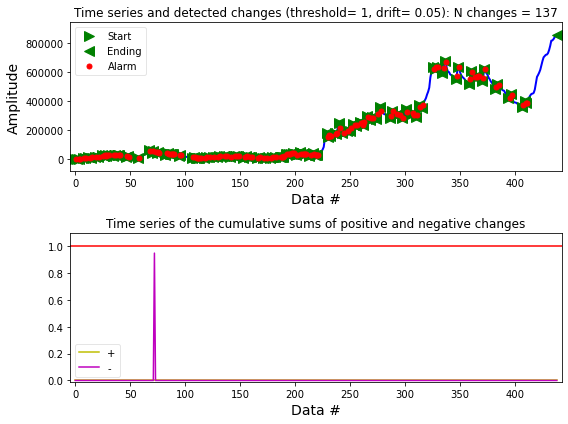

(array([  1,   3,   4,   8,  10,  13,  15,  19,  22,  25,  27,  28,  29,
         31,  35,  37,  40,  41,  47,  49,  58,  68,  71,  73,  75,  76,
         83,  85,  87,  88,  89,  90,  95,  96, 107, 109, 111, 112, 113,
        114, 118, 120, 123, 126, 130, 132, 136, 138, 142, 145, 147, 149,
        154, 156, 159, 161, 166, 168, 172, 174, 178, 180, 183, 187, 188,
        189, 190, 193, 194, 195, 197, 199, 202, 205, 207, 208, 209, 210,
        214, 217, 219, 220, 221, 230, 231, 232, 233, 237, 238, 241, 244,
        248, 251, 254, 256, 260, 261, 262, 263, 266, 269, 271, 275, 278,
        287, 289, 293, 295, 298, 302, 307, 308, 311, 314, 316, 326, 328,
        330, 335, 337, 347, 349, 359, 361, 364, 365, 366, 367, 371, 373,
        383, 385, 395, 397, 407, 410, 411]),
 array([  0,   2,   3,   7,   9,  12,  14,  18,  21,  24,  26,  27,  28,
         30,  34,  36,  39,  40,  46,  48,  57,  67,  70,  71,  74,  75,
         82,  84,  86,  87,  88,  89,  94,  95, 106, 108, 110, 111, 112,
      

In [40]:
detect_cusum(sig1, 1, .05, True, True)

## 4. OneClass SVM

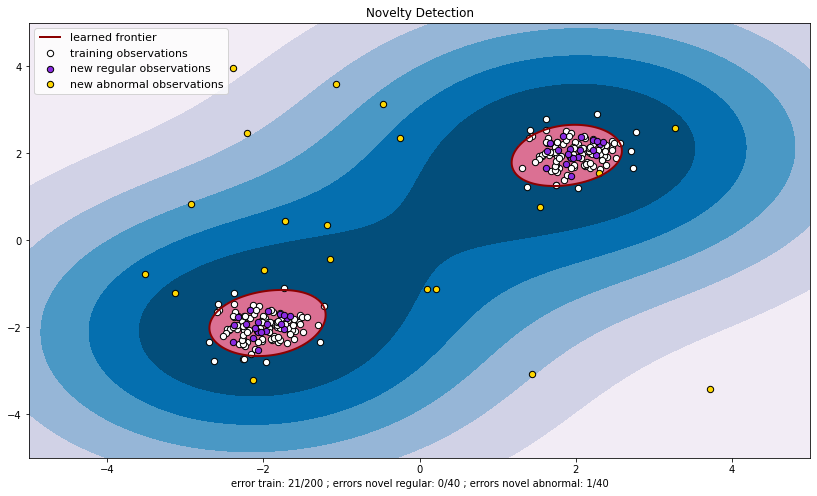

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(14,8))
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

### Sig 1

In [47]:
sig1.__len__()

439

In [48]:
sig1[0], sig1[-1]

(4742.0, 856505.0)

In [51]:
sig1 = np.array(sig1).reshape(-1, 1)

In [52]:
clf = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01)
clf.fit(sig1[:300])

y_pred_train = clf.predict(sig1[:300])
y_pred_test = clf.predict(sig1[300:])

In [53]:
y = np.linspace(4500, 860000, 500).reshape(-1, 1)
Z = clf.decision_function(y).reshape(-1, 1)
Z = np.hstack((Z, Z))
y = y.reshape(500)

In [54]:
false_positive_train = []
false_positive_test = []
for i, t in enumerate(y_pred_train):
    if t != 1:
        false_positive_train.append((i, sig1[i]))
        
for i, t in enumerate(y_pred_test):
    if t != 1:
        idx = len(y_pred_train) + i
        false_positive_test.append((idx, sig1[idx]))

In [55]:
false_positive_train = np.array(false_positive_train)
false_positive_test = np.array(false_positive_test)

<ipython-input-55-6d23dc9b578e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  false_positive_train = np.array(false_positive_train)
<ipython-input-55-6d23dc9b578e>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  false_positive_test = np.array(false_positive_test)


<ipython-input-63-46edc0113b62>:3: UserWarning: No contour levels were found within the data range.
  plt.contour([0, 450], y, Z, levels=[0], linewidths=10, colors='darkred')


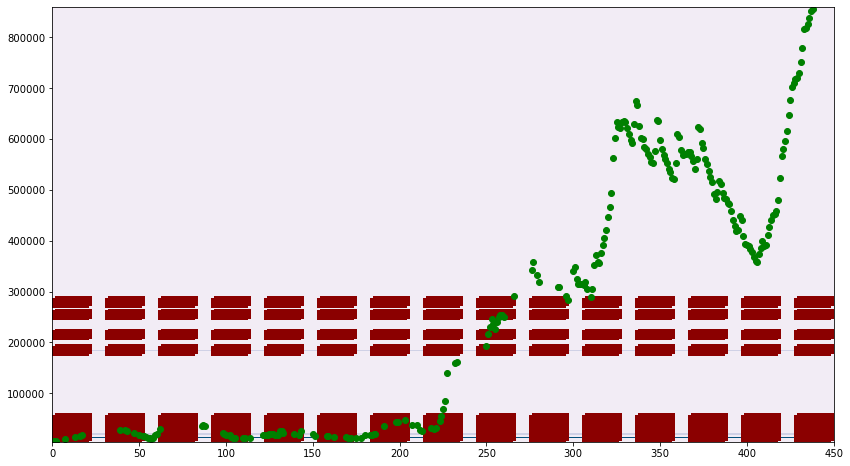

In [63]:
plt.figure(figsize=(14,8))
plt.contourf([0, 450], y, Z, cmap=plt.cm.PuBu)
plt.contour([0, 450], y, Z, levels=[0], linewidths=10, colors='darkred')
plt.plot(range(300), sig1[:300], 'wo', linewidth=10)
plt.plot(range(300), sig1[:300], 'w-', linewidth=2)
plt.plot(range(300,439), sig1[300:], 'bo', linewidth=10)
plt.plot(range(299,439), sig1[299:], 'b-', linewidth=2)
plt.plot(false_positive_train[:, 0], false_positive_train[:, 1], 'go')
plt.plot(false_positive_test[:, 0], false_positive_test[:, 1], 'go')
plt.show()

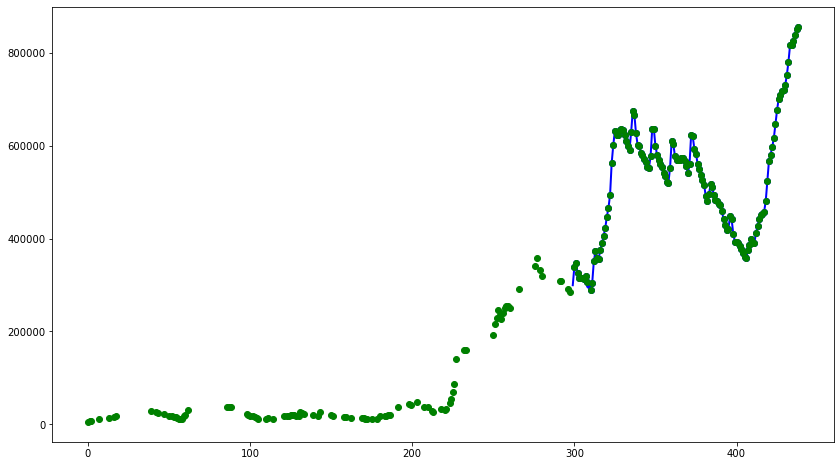

In [73]:
plt.figure(figsize=(14,8))
# plt.contourf([0, 450], y, Z, cmap=plt.cm.PuBu)
# plt.contour([0, 450], y, Z, levels=[0], linewidths=10, colors='darkred')
plt.plot(range(300), sig1[:300], 'wo', linewidth=10)
plt.plot(range(300), sig1[:300], 'w-', linewidth=2)
plt.plot(range(300,439), sig1[300:], 'bo', linewidth=10)
plt.plot(range(299,439), sig1[299:], 'b-', linewidth=2)
plt.plot(false_positive_train[:, 0], false_positive_train[:, 1], 'go')
plt.plot(false_positive_test[:, 0], false_positive_test[:, 1], 'go')
plt.show()

Чего то не учел насчет коридора, но график и предсказания достаточно точные 

## 5 sklearn.ensemble.IsolationForest¶
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

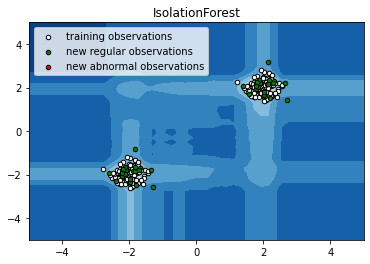

In [115]:
rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# print(X_train)
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
# X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
# y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
# print(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
# print(np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50)))
# print(xx.ravel(), yy.ravel())
# print(np.c_[xx.ravel(), yy.ravel()])
# print(len(np.c_[xx.ravel(), yy.ravel()]))
# print(clf.decision_function(np.c_[xx.ravel(), yy.ravel()]))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
# c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
#                 s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

In [118]:
X_train[:, 0]

array([ 2.149,  2.194,  1.93 ,  2.474,  1.859,  1.861,  2.073,  1.483,
        1.696,  1.728,  2.44 ,  2.02 ,  1.837,  1.655,  1.82 ,  1.819,
        1.996,  2.247,  2.063,  1.602,  2.222,  1.965,  1.556,  1.862,
        2.103,  2.097,  1.797,  2.309,  1.748,  2.099,  1.856,  1.668,
        2.244,  1.978,  2.108,  2.108,  1.989,  1.214,  2.026,  2.028,
        1.934,  2.443,  1.757,  2.275,  1.841,  2.029,  1.789,  1.882,
        2.089,  2.002,  1.575,  1.897,  1.952,  2.566,  2.077,  1.424,
        2.018,  1.942,  1.99 ,  2.343,  2.237,  2.421,  2.176,  1.703,
        2.03 ,  1.535,  1.681,  1.724,  1.765,  2.244,  2.068,  1.518,
        2.078,  1.629,  2.157,  2.075,  1.796,  2.088,  2.56 ,  1.643,
        1.708,  2.348,  2.289,  2.247,  1.926,  1.733,  1.977,  2.083,
        2.004,  1.921,  2.188,  1.679,  1.933,  2.142,  1.746,  1.866,
        2.064,  2.052,  1.735,  2.017, -1.851, -1.806, -2.07 , -1.526,
       -2.141, -2.139, -1.927, -2.517, -2.304, -2.272, -1.56 , -1.98 ,
      

In [119]:
X_train[:, 1]

array([ 1.959,  2.457,  1.93 ,  2.23 ,  2.163,  1.86 ,  1.426,  1.831,
        2.094,  1.576,  1.932,  1.573,  2.033,  2.113,  1.912,  2.556,
        1.683,  1.634,  1.412,  2.059,  2.051,  1.91 ,  1.784,  2.317,
        1.471,  1.884,  2.184,  2.279,  1.907,  2.293,  1.944,  1.641,
        2.407,  2.301,  1.806,  2.461,  2.469,  2.247,  1.91 ,  1.404,
        2.107,  1.845,  1.849,  2.099,  2.154,  2.291,  1.902,  1.561,
        2.078,  1.93 ,  1.874,  1.759,  2.121,  2.052,  1.978,  1.992,
        2.739,  2.09 ,  1.649,  2.226,  1.727,  1.579,  2.657,  1.83 ,
        1.849,  2.021,  2.142,  2.465,  1.903,  1.631,  2.392,  2.055,
        2.235,  1.604,  2.089,  2.104,  2.07 ,  1.786,  2.142,  2.197,
        2.236,  1.754,  2.124,  2.569,  1.774,  1.755,  2.102,  2.248,
        2.436,  2.816,  1.743,  2.145,  2.214,  1.978,  1.546,  2.257,
        1.626,  2.116,  2.046,  1.657, -2.041, -1.543, -2.07 , -1.77 ,
       -1.837, -2.14 , -2.574, -2.169, -1.906, -2.424, -2.068, -2.427,
      

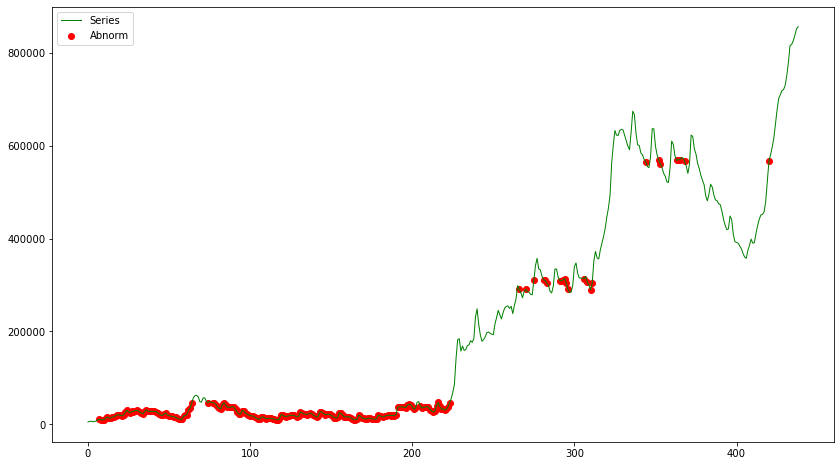

In [133]:
from sklearn.ensemble import IsolationForest

df_sig1 = pd.DataFrame(sig1, columns = ['val'])

                      
clf = IsolationForest(max_samples=100, random_state=42)
clf.fit(sig1)

df_sig1['pred'] = clf.predict(sig1)

df_abnorm = df_sig1[df_sig1['pred'] != -1]
plt.figure(figsize=(14,8))

plt.plot(sig1, linestyle = '-',
        linewidth = 1,
        color = 'green', 
        label = 'Series')

plt.scatter(df_abnorm.index, df_abnorm['val'], color='red', label = 'Abnorm')
plt.legend()
    
plt.show()

Так и не смог разобраться с пятым методом. Идея ясна, а практическая применимость не очень.